# Markov chain transmission rate 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import pandas as pd
import random

In [319]:
# Solves compartmental SIS model with transmission matrix beta (row: susceptible, column: infected)

class ConditionalSIS:
    def __init__(self, beta, gamma, initial_s, initial_i, endtime):
        self.cases = len(beta)
        self.b = beta
        self.k = gamma
        self.S_0 = initial_s
        self.I_0 = initial_i
        self.y0 = np.append(self.S_0, self.I_0)
        self.N = self.S_0 + self.I_0
        self.t0 = 0
        self.tEnd = endtime
        
        self.simulation = []
        self.timestamps = []
        
    def fun(self, t, y):
        stois = [] #susceptible to infected
        for idx in range(self.cases):
            # infection rate is the dot product between the corresponding row in the transmission matrix and all of the infection compartments
            infection_rate = np.matmul(self.b[idx], y[self.cases:2 * self.cases]/self.N) 
            recovered_population = self.k[idx] * y[self.cases + idx]
            stois.append(y[idx] * infection_rate - recovered_population)

        stois = np.array(stois)
        
        return np.append(-stois, stois) # dS = -stois, dI = stois

    def simulate(self):
        sol = solve_ivp(self.fun, [self.t0 , self.tEnd], self.y0, method='BDF')
        self.simulation = sol.y
        self.timestamps = sol.t
    
    def plot(self, compartment):
        for i in range(self.cases):
            plt.plot(self.timestamps, self.simulation[compartment * self.cases + i])
            


In [320]:
b = [[0.02, 0.02], [0.0002, 0.0002]]
k = [0.00001, 0.00001]

In [299]:
b = np.array([[0.1, 0.1], [1, 1]]) # row i indicates population i's transmission rate from each of the other infected populations
k = np.array([0.1, 0.05])

In [321]:
sis = ConditionalSIS(beta = b, gamma = k, initial_s = np.array([190, 100]), initial_i = np.array([10, 0]), endtime = 1000)

In [322]:
sis.simulate()

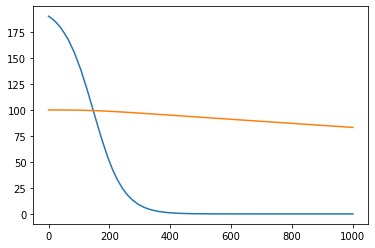

In [323]:
sis.plot(0)

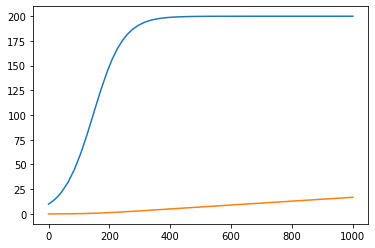

In [304]:
sis.plot(1)

In [71]:
# Solves compartmental SIR model with transmission matrix beta (row: susceptible, column: infected) and recovery vector gamma

class ConditionalSIR:
    def __init__(self, beta, gamma, initial_s, initial_i, initial_r, endtime):
        self.cases = len(beta)
        self.b = beta
        self.k = gamma
        self.S_0 = initial_s
        self.I_0 = initial_i
        self.R_0 = initial_r
        self.y0 = np.append(np.append(self.S_0, self.I_0), self.R_0)
        self.N = self.S_0 + self.I_0 + self.R_0
        self.t0 = 0
        self.tEnd = endtime
        
        self.simulation = []
        self.timestamps = []
        
    def fun(self, t, y):
        stois = [] #susceptible to infected
        itors = [] #infected to recovered
        for idx in range(self.cases):
            # infection rate is the dot product between the corresponding row in the transmission matrix and all of the infection compartments
            infection_rate = np.matmul(self.b[idx], y[self.cases:2 * self.cases]/self.N) 
            stois.append(y[idx] * infection_rate)
            itors.append(self.k[idx] * y[self.cases + idx])

        stois = np.array(stois)
        itors = np.array(itors)
        
        return np.append(np.append(-stois, stois - itors), itors) # dS = -stois, dI = stoid - itos, dR = itors

    def simulate(self):
        sol = solve_ivp(self.fun, [self.t0 , self.tEnd], self.y0, method='BDF')
        self.simulation = sol.y
        self.timestamps = sol.t
    
    def plot(self, compartment = 0):
        for i in range(self.cases):
            plt.plot(self.timestamps, self.simulation[compartment * self.cases + i])
            


In [72]:
sir = ConditionalSIR(beta = b, gamma = k, initial_s = np.array([190, 100]), initial_i = np.array([10, 0]), initial_r = np.array([0, 0]), endtime = 100)

In [73]:
sir.simulate()

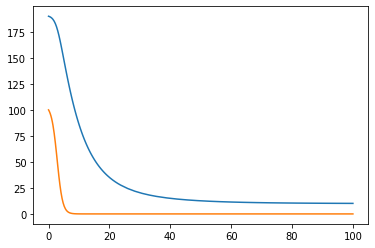

In [74]:
sir.plot()

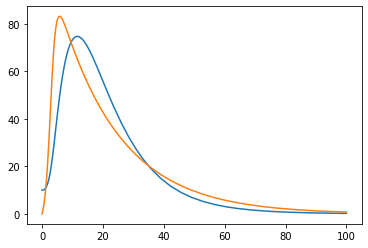

In [75]:
sir.plot(1)

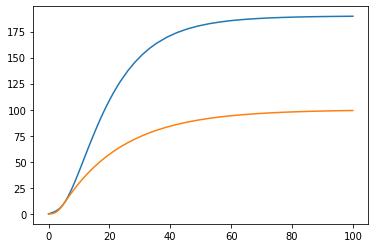

In [76]:
sir.plot(2)

In [354]:
# Solves DTMC SIS model with transmission matrix beta (row: susceptible, column: infected) and recovery vector omega

class DTMCSIS:
    def __init__(self, beta, gamma, initial_s, initial_i, endtime):
        self.cases = len(beta)
        self.b = beta
        self.k = gamma
        self.S_0 = initial_s
        self.I_0 = initial_i
        self.N = self.S_0 + self.I_0
        self.timestamps = np.linspace(0, endtime, endtime + 1)
        self.susceptible = [self.S_0]
        self.infected = [self.I_0]
        
    def trans_step(self, total, infected, infected_vector, bvec, kval):
        p1 = (total - infected)/total * np.matmul(bvec, infected_vector)
        p2 = kval * infected

        u = random.uniform(0,1)
        if u <= p1:
            return 1
        elif u <= p1 + p2:
            return -1
        else:
            return 0
    
    def simulate(self):
        self.N = self.S_0 + self.I_0
        self.susceptible = [self.S_0]
        self.infected = [self.I_0]
        
        for _ in timestamps[1:]:
            curr_i = self.infected[-1].copy()
            for i in range(cases):
                infected_pop = curr_i[i]
                infected_pop += self.trans_step(self.N[i], infected_pop, curr_i, self.b[i], self.k[i])
                curr_i[i] = infected_pop

            self.susceptible.append(N - curr_i)
            self.infected.append(curr_i)
    
    def plot(self, compartment):
        arr = None
        if compartment == 0:
            arr = np.array(self.susceptible).T
        else:
            arr = np.array(self.infected).T

        for i in range(self.cases):
            plt.plot(self.timestamps, arr[i])
            


In [355]:
dsis = DTMCSIS(b, k, [190, 100], [10, 0], 1000)

In [358]:
dsis.simulate()

In [ ]:
dsis

In [343]:
np.array(dsis.infected).T[1]

array([ 0,  0,  0, ..., 31, 31, 31])

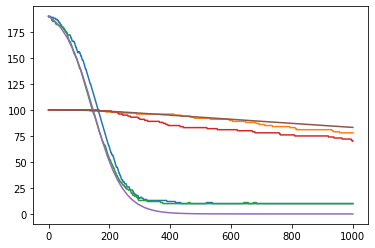

In [391]:
for i in range(2):
    dsis.simulate()
    dsis.plot(0)
sis.plot(0)
plt.show()

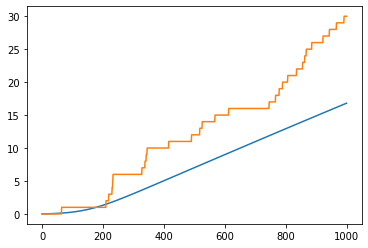

In [364]:
plt.plot(sis.timestamps, sis.simulation[sis.cases * 1 + 1])
plt.plot(dsis.timestamps, np.array(dsis.infected).T[1])
plt.show()

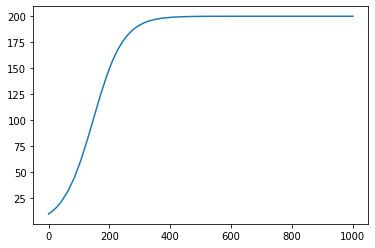

In [339]:
plt.plot(sis.timestamps, sis.simulation[sis.cases * 1])

In [340]:
sis.simulation[sis.cases * 1 + 1]

array([0.00000000e+00, 4.47205533e-06, 8.94448470e-06, 5.37017384e-05,
       9.84965394e-05, 5.48499628e-04, 1.00233203e-03, 1.46005600e-03,
       4.44398870e-03, 7.59345179e-03, 1.09167508e-02, 2.14868265e-02,
       3.37887979e-02, 4.80799246e-02, 6.46471605e-02, 1.21846557e-01,
       2.03908507e-01, 3.18262780e-01, 4.72005478e-01, 6.70291059e-01,
       9.27744577e-01, 1.23301198e+00, 1.47795658e+00, 1.74048341e+00,
       2.01727757e+00, 2.30535722e+00, 2.60215231e+00, 2.98336388e+00,
       3.37169477e+00, 3.63258073e+00, 3.89505279e+00, 4.15872791e+00,
       4.42329213e+00, 4.77764063e+00, 5.13271797e+00, 5.48823736e+00,
       5.84399580e+00, 6.19984482e+00, 6.48484904e+00, 6.76980308e+00,
       7.05467714e+00, 7.33944758e+00, 7.62409566e+00, 7.90860661e+00,
       8.85603181e+00, 9.15258046e+00, 9.44892805e+00, 9.74506802e+00,
       1.00409940e+01, 1.03366998e+01, 1.06321799e+01, 1.10966198e+01,
       1.15604668e+01, 1.20237005e+01, 1.24863006e+01, 1.29482476e+01,
      

In [333]:
np.array(dsis.infected).T

array([[ 10,  10,  10, ..., 190, 190, 190],
       [  0,   0,   0, ...,  31,  31,  31]])

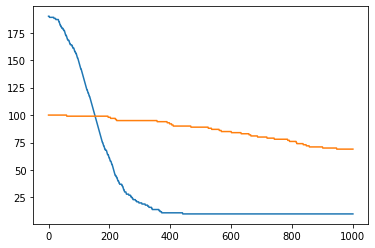

In [327]:
dsis.plot(0)

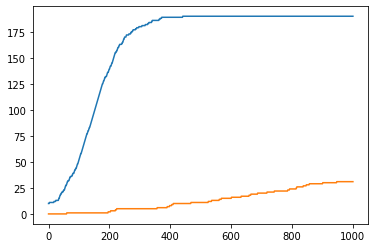

In [328]:
dsis.plot(1)

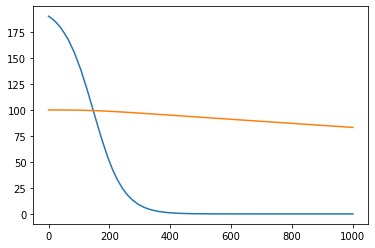

In [329]:
sis.plot(0)

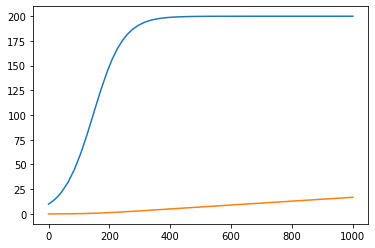

In [330]:
sis.plot(1)

In [ ]:
fig,ax = plt.subplot()
sis.plot(1, ax = ax)
dsis.plot(1, ax = ax)
plt.show()